<a href="https://colab.research.google.com/github/cristopher-d-delgado/image_classification_pneumonia/blob/main/mlp_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection on Chest X-Rays

In [1]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

In [2]:
# # Google Drive connection

# from google.colab import drive
# drive.mount('/content/drive/')

# Explore our Data & Preprocess

In [3]:
import os
# Create a path to the root folder and path to specific folders on my computer
# data_path = '/content/drive/MyDrive/Flatiron/phase4/chest_xray/chest_xray'
# data_path = 'data\chest_xray\chest_xray'
data_path = "data/chest_xray/"
#data_path = "data/CellData/chest_xray/"
data_path

# Specificy paths for train, test, val
train_folder = os.path.join(data_path, 'train/')
test_folder = os.path.join(data_path, 'test/')
val_folder = os.path.join(data_path, 'validation/')

# Specify paths for labels
train_normal = os.path.join(train_folder, 'NORMAL')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, "NORMAL")
test_pneumonia = os.path.join(test_folder, "PNEUMONIA")
val_normal = os.path.join(val_folder, "NORMAL")
val_pneumonia = os.path.join(val_folder, "PNEUMONIA")

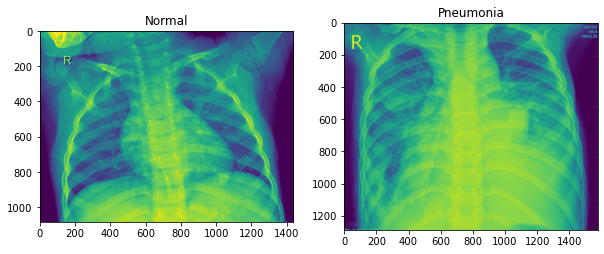

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Read images
# img1 = Image.open("/content/drive/MyDrive/Flatiron/phase4/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
# img2 = Image.open("/content/drive/MyDrive/Flatiron/phase4/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
# img1 = Image.open("data/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
# img2 = Image.open("data/chest_xray/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")

# img1 = Image.open(r"data\CellData\chest_xray\train\NORMAL\NORMAL-32326-0001.jpeg")
# img2 = Image.open(r"data\CellData\chest_xray\train\PNEUMONIA\BACTERIA-37006-0002.jpeg")


img1 = Image.open(r"data\chest_xray\train\NORMAL\NORMAL-32326-0001.jpeg")
img2 = Image.open(r"data\chest_xray\train\PNEUMONIA\BACTERIA-37006-0002.jpeg")

# Display images side by side
plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Normal')

# Plot the second image
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Pneumonia')

plt.show()

It seems that the images are not actually on the same size. Visually we can see the bacterial infection. We would have to preprocess the images to become the same size and also lower the scale since training a neuwral network is resource intensive. Lets explore how many images we have in each directory.

In [5]:
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(test_normal)), 'normal images in the testing set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the testing set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')

There are 1215 normal images in the training set
There are 2719 pneumonia images in the training set
________________________________________________________________________________________
There are 235 normal images in the testing set
There are 390 pneumonia images in the testing set
________________________________________________________________________________________
There are 134 normal images in the validation set
There are 1164 pneumonia images in the validation set


Lets preprocess the images by resizing to (256, 256, 3)

In [6]:
from functions import process_data

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

# Preprocess data with our function
train_gen, test_gen, val_gen = process_data(256, 32, train_data_dir, test_data_dir, val_data_dir)

Found 3934 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1298 images belonging to 2 classes.


It seems the generators are working as expected. The main downside is that the image genertaor does not let us know what images are normal and pneumonia but its labeled for us as 1, 0. Lets take a batch of images and see what we see so we know what is Normal and Peneumonia.

Image dimensions: (256, 256, 3)


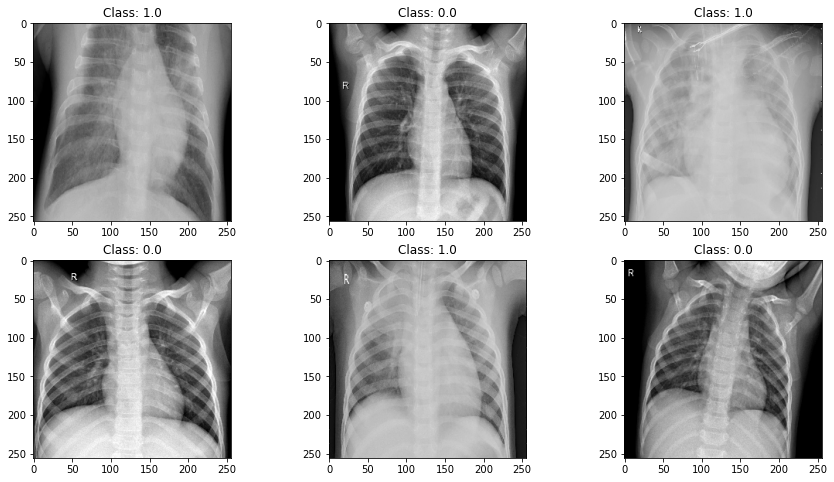

In [7]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].imshow(images[0])
ax[0, 0].set_title(f"Class: {labels[0]}")

ax[0, 1].imshow(images[1])
ax[0, 1].set_title(f"Class: {labels[1]}")

ax[0, 2].imshow(images[2])
ax[0, 2].set_title(f"Class: {labels[2]}")

ax[1, 0].imshow(images[3])
ax[1, 0].set_title(f"Class: {labels[3]}")

ax[1, 1].imshow(images[4])
ax[1, 1].set_title(f"Class: {labels[4]}")

ax[1, 2].imshow(images[5])
ax[1, 2].set_title(f"Class: {labels[5]}")

plt.show()

It seems images that arer very cloudy in the chest are Pneumonia while normal images are very clear. This means 1 is Pneumonia and 0 is Normal.

Image dimensions: (256, 256, 3)


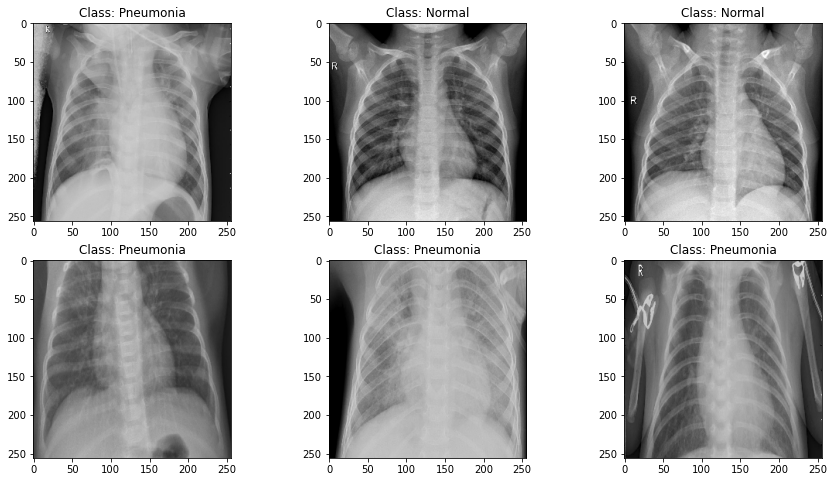

In [8]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].imshow(images[0])
ax[0, 0].set_title(f"Class: {'Normal' if labels[0] == 0 else 'Pneumonia'}")

ax[0, 1].imshow(images[1])
ax[0, 1].set_title(f"Class: {'Normal' if labels[1] == 0 else 'Pneumonia'}")

ax[0, 2].imshow(images[2])
ax[0, 2].set_title(f"Class: {'Normal' if labels[2] == 0 else 'Pneumonia'}")

ax[1, 0].imshow(images[3])
ax[1, 0].set_title(f"Class: {'Normal' if labels[3] == 0 else 'Pneumonia'}")

ax[1, 1].imshow(images[4])
ax[1, 1].set_title(f"Class: {'Normal' if labels[4] == 0 else 'Pneumonia'}")

ax[1, 2].imshow(images[5])
ax[1, 2].set_title(f"Class: {'Normal' if labels[5] == 0 else 'Pneumonia'}")

plt.show()


We sucecssfully resized the images and also created an RGB tensor. Lets create our datasets

# Make an Multilayer Perceptrons Model

I don't expect great perfomance in comparison to a Convuluted Neural Network. For the sake of trying we should attempt a basic neural network before getting more complex using basic MLP layers

**Base MLP Model:**

Define Base Model

We can attempt to train the model by iterating over the numebr of epochs. We can then save look at the validation and training loss and see where it begins to overfit.

In [9]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log
METRICS = metrics=[
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]

In [10]:
import time
import pandas as pd
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam


# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base = Sequential()

# Define the layers 
model_mlp_base.add(Flatten(input_shape=input_shape))
model_mlp_base.add(Dense(64, activation='relu'))
model_mlp_base.add(Dense(1, activation='sigmoid'))
model_mlp_base.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                12582976  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 12,583,041
Trainable params: 12,583,041
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
from functions import train_model

mlp = {}
mlp['Version1'] = train_model(model_mlp_base, train_gen, val_gen, total_epochs=15)

Epoch 1/15
  1/158 [..............................] - ETA: 0s - loss: 0.5365 - precision: 0.7812 - recall: 1.0000 - accuracy: 0.7812WARNING:tensorflow:From c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
158/158 [==============================] - 41s 260ms/step - loss: 5.5835 - precision: 0.8967 - recall: 0.9014 - accuracy: 0.8478 - val_loss: 2.3692 - val_precision: 1.0000 - val_recall: 0.7800 - val_accuracy: 0.8900
Epoch 2/15
158/158 [==============================] - 40s 252ms/step - loss: 2.0568 - precision: 0.9384 - recall: 0.9376 - accuracy: 0.9068 - val_loss: 1.9741 - val_precision: 0.8115 - val_recall: 0.9900 - val_accuracy: 0.8800
Epoch 3/15
158/158 [==============================] - 39s 246ms/step - loss: 1.5263 - precision: 0.9527 - recall: 0.9527 - accur

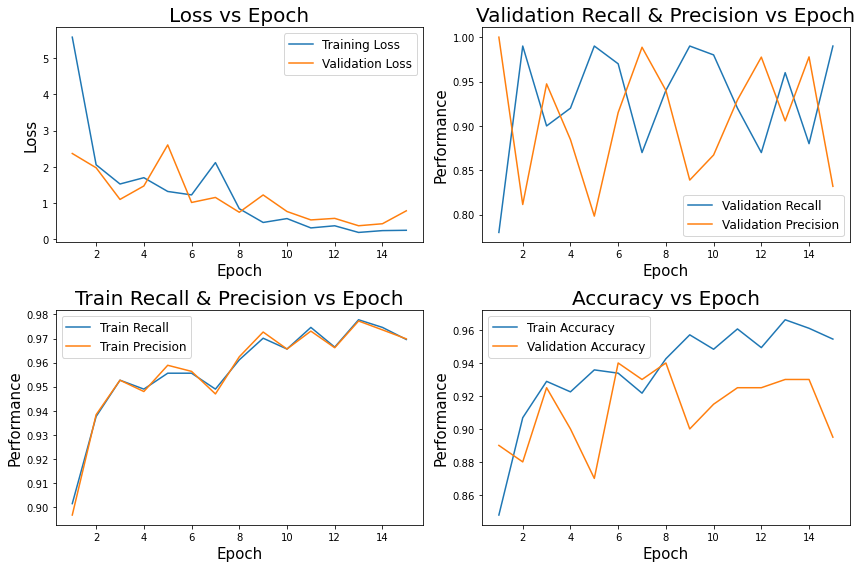

In [12]:
from functions import view_history

view_history(mlp, 'Version1')

In [13]:
from functions import model_evaluate

model_evaluate(model_mlp_base, train_gen, test_gen, val_gen)

7/7 [==============================] - 2s 223ms/step - loss: 0.7852 - precision: 0.8319 - recall: 0.9900 - accuracy: 0.8950


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.169925,96.222562,99.656355,96.800476
1,Test,2.923306,74.710423,99.230766,78.525639
2,Validation,0.785198,83.193278,99.000001,89.499998


This looks good. We generally follow closely with both curves. We can still add more neurons or add another layer to see if we are still generalizing well to capture more of the data. 

# MLP Version 2

In [14]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_2 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_2.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_2.add(Dense(64, activation='relu'))
model_mlp_base_2.add(Dense(64, activation='relu'))

# Define output layer
model_mlp_base_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                12582976  
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 12,587,201
Trainable params: 12,587,201
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
from functions import train_model
# Update our dictionary with Version 2

mlp['Version2'] = train_model(model_mlp_base_2, train_gen, val_gen, total_epochs=15)

Epoch 1/15
158/158 [==============================] - 41s 259ms/step - loss: 1.8448 - precision: 0.8907 - recall: 0.8942 - accuracy: 0.8378 - val_loss: 0.1861 - val_precision: 0.8899 - val_recall: 0.9700 - val_accuracy: 0.9250
Epoch 2/15
158/158 [==============================] - 39s 245ms/step - loss: 0.3908 - precision: 0.9313 - recall: 0.9389 - accuracy: 0.9020 - val_loss: 0.1812 - val_precision: 0.9394 - val_recall: 0.9300 - val_accuracy: 0.9350
Epoch 3/15
158/158 [==============================] - 39s 245ms/step - loss: 0.1892 - precision: 0.9581 - recall: 0.9601 - accuracy: 0.9384 - val_loss: 0.4710 - val_precision: 0.7795 - val_recall: 0.9900 - val_accuracy: 0.8550
Epoch 4/15
158/158 [==============================] - 38s 244ms/step - loss: 0.2060 - precision: 0.9521 - recall: 0.9572 - accuracy: 0.9316 - val_loss: 0.6069 - val_precision: 1.0000 - val_recall: 0.7200 - val_accuracy: 0.8600
Epoch 5/15
158/158 [==============================] - 39s 244ms/step - loss: 0.1868 - precis

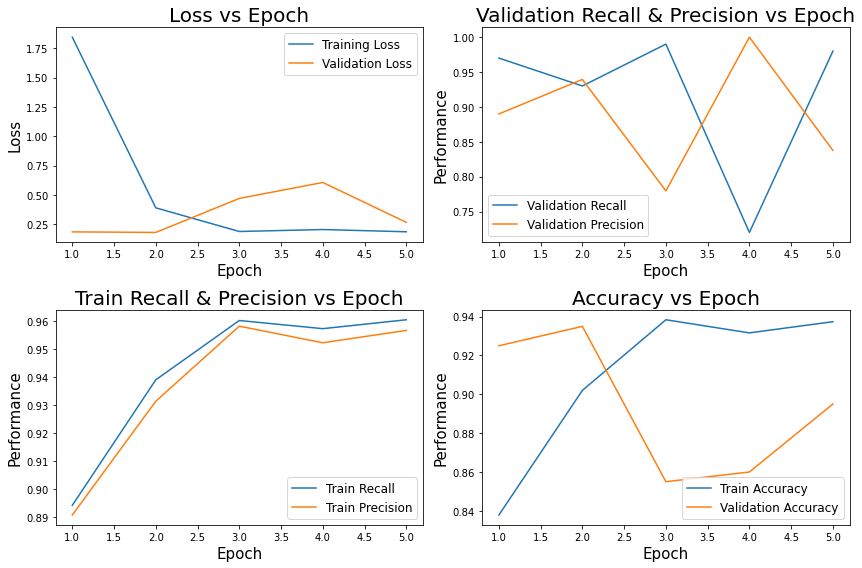

In [16]:
from functions import view_history
# Visualize the history 

view_history(mlp, 'Version2')

In [19]:
from functions import model_evaluate
# Evaluate the model

model_evaluate(model_mlp_base_2, train_gen, test_gen, val_gen)

7/7 [==============================] - 2s 216ms/step - loss: 0.4461 - precision: 0.9888 - recall: 0.8800 - accuracy: 0.9350


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.406071,98.744649,91.488236,92.726552
1,Test,0.771114,88.377726,93.589741,88.301283
2,Validation,0.446106,98.876405,88.000000,93.500000


It seems that adding another layer made the model overfit. We can see that because the loss curves diverged from eachother. One solution here would be to include regularization to see if we can address this

# MLP Version 3

In [17]:
from tensorflow.keras import Input, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_3 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_3.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_3.add(Dense(64, activation='relu'))
model_mlp_base_3.add(Dense(64, activation='relu', kernel_regularizer='l2'))
# Define output layer
model_mlp_base_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_3.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                12582976  
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 12,587,201
Trainable params: 12,587,201
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
# Update our dictionary with Version 3
mlp['Version3'] = train_model(model_mlp_base_3, train_gen, val_gen, total_epochs=30)

Epoch 1/30
158/158 [==============================] - 40s 255ms/step - loss: 2.1798 - precision: 0.8425 - recall: 0.8681 - accuracy: 0.7772 - val_loss: 0.5300 - val_precision: 0.8000 - val_recall: 0.9600 - val_accuracy: 0.8600
Epoch 2/30
158/158 [==============================] - 38s 242ms/step - loss: 0.3869 - precision: 0.9470 - recall: 0.9588 - accuracy: 0.9287 - val_loss: 0.3629 - val_precision: 0.9778 - val_recall: 0.8800 - val_accuracy: 0.9300
Epoch 3/30
158/158 [==============================] - 38s 242ms/step - loss: 0.3432 - precision: 0.9542 - recall: 0.9635 - accuracy: 0.9378 - val_loss: 0.3401 - val_precision: 0.9286 - val_recall: 0.9100 - val_accuracy: 0.9200
Epoch 4/30
158/158 [==============================] - 38s 243ms/step - loss: 0.3260 - precision: 0.9580 - recall: 0.9646 - accuracy: 0.9416 - val_loss: 0.3246 - val_precision: 0.9570 - val_recall: 0.8900 - val_accuracy: 0.9250
Epoch 5/30
158/158 [==============================] - 38s 240ms/step - loss: 0.3087 - precis

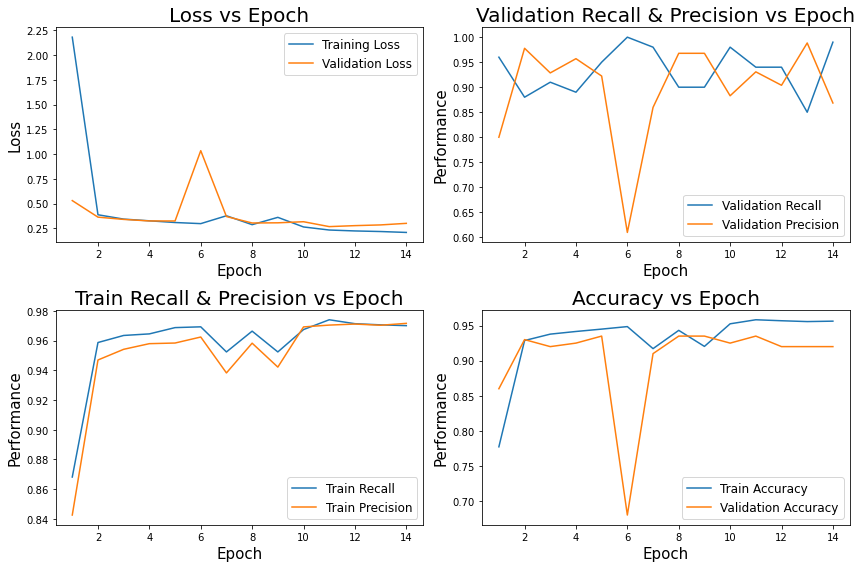

In [21]:
# Visualize the history 
from functions import view_history
view_history(mlp, 'Version3')

In [20]:
# Evaluate the model
from functions import model_evaluate
model_evaluate(model_mlp_base_3, train_gen, test_gen, val_gen)

7/7 [==============================] - 1s 207ms/step - loss: 0.3003 - precision: 0.8684 - recall: 0.9900 - accuracy: 0.9200


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.176271,97.119129,98.916203,96.979332
1,Test,0.823102,76.846308,98.717946,80.608976
2,Validation,0.300283,86.842108,99.000001,92.000002


This is interesting, there was a moment when our loss curves divereged at around epoch 5. The curves soon after returned back to closely following eachother. We can see that our train loss and validation loss decreased from .4 and .4 to .17 and .3 respectively. We do address the overfit from our seconf version MLP but now it seems we lost quite a buit of information. Lets add another layer to see if this will affect our train and val loss overall and maybe lower our test loss.

# MLP Version 4

In [22]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_4 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_4.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_4.add(Dense(64, activation='relu'))
model_mlp_base_4.add(Dense(64, activation='relu'))
model_mlp_base_4.add(Dense(64, activation='relu', kernel_regularizer='l2'))

# Define output layer
model_mlp_base_4.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_4.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                12582976  
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 12,591,361
Trainable params: 12,591,361
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# Update our dictionary with Version 4
mlp['Version4'] = train_model(model_mlp_base_4, train_gen, val_gen, total_epochs=15)

Epoch 1/15
158/158 [==============================] - 40s 256ms/step - loss: 3.3075 - precision: 0.8703 - recall: 0.8931 - accuracy: 0.8180 - val_loss: 0.5019 - val_precision: 0.9468 - val_recall: 0.8900 - val_accuracy: 0.9200
Epoch 2/15
158/158 [==============================] - 38s 241ms/step - loss: 0.5547 - precision: 0.9288 - recall: 0.9381 - accuracy: 0.8994 - val_loss: 0.5174 - val_precision: 0.8390 - val_recall: 0.9900 - val_accuracy: 0.9000
Epoch 3/15
158/158 [==============================] - 38s 240ms/step - loss: 0.4143 - precision: 0.9574 - recall: 0.9633 - accuracy: 0.9402 - val_loss: 0.4445 - val_precision: 0.8818 - val_recall: 0.9700 - val_accuracy: 0.9200
Epoch 4/15
158/158 [==============================] - 38s 239ms/step - loss: 0.4209 - precision: 0.9565 - recall: 0.9582 - accuracy: 0.9358 - val_loss: 0.6463 - val_precision: 0.7615 - val_recall: 0.9900 - val_accuracy: 0.8400
Epoch 5/15
158/158 [==============================] - 38s 239ms/step - loss: 0.3804 - precis

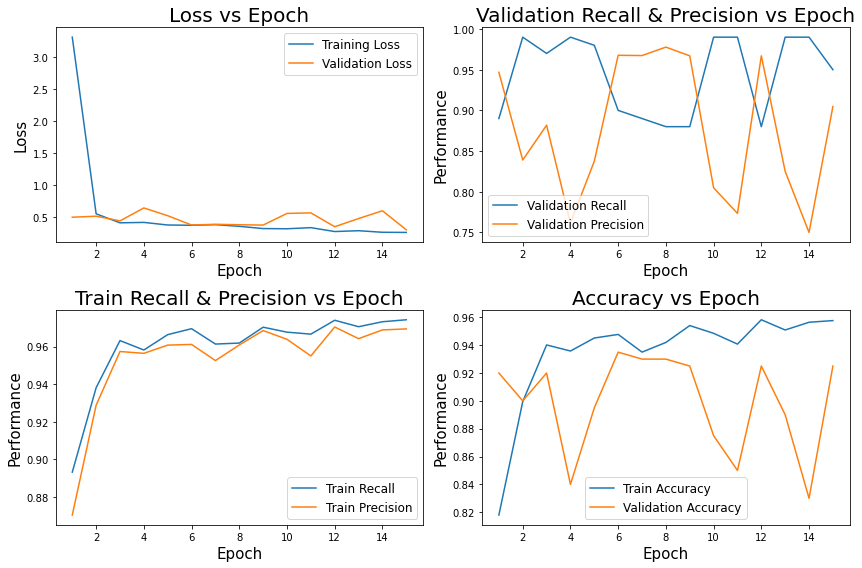

In [24]:
# Visualize the history 
from functions import view_history
view_history(mlp, 'Version4')

In [25]:
# Evaluate the model
from functions import model_evaluate
model_evaluate(model_mlp_base_4, train_gen, test_gen, val_gen)

7/7 [==============================] - 2s 217ms/step - loss: 0.3053 - precision: 0.9048 - recall: 0.9500 - accuracy: 0.9250


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.216967,98.435426,98.123181,97.416532
1,Test,0.726080,80.375785,98.717946,84.134614
2,Validation,0.305269,90.476191,94.999999,92.500001


It seems our intuition was correct in adding a layer. It seem we havent overfitted yet as our loss curves still follow eachother. Lets add anotehr layer to genralize better

# MLP Version 5

In [26]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_5 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_5.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_5.add(Dense(64, activation='relu'))
model_mlp_base_5.add(Dense(64, activation='relu'))
model_mlp_base_5.add(Dense(64, activation='relu'))
model_mlp_base_5.add(Dense(64, activation='relu', kernel_regularizer='l2'))

# Define output layer
model_mlp_base_5.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_5.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                12582976  
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 12,595,521
Trainable params: 12,595,521
Non-trainable params: 0
__________________________________________

In [27]:
mlp['Version5'] = train_model(model_mlp_base_5, train_gen, val_gen, total_epochs=15)

Epoch 1/15
158/158 [==============================] - 41s 258ms/step - loss: 1.2696 - precision: 0.8577 - recall: 0.8645 - accuracy: 0.7878 - val_loss: 2.5752 - val_precision: 0.5025 - val_recall: 1.0000 - val_accuracy: 0.5050
Epoch 2/15
158/158 [==============================] - 38s 243ms/step - loss: 0.5484 - precision: 0.9339 - recall: 0.9450 - accuracy: 0.9084 - val_loss: 0.5083 - val_precision: 1.0000 - val_recall: 0.8600 - val_accuracy: 0.9300
Epoch 3/15
158/158 [==============================] - 38s 240ms/step - loss: 0.4450 - precision: 0.9510 - recall: 0.9598 - accuracy: 0.9326 - val_loss: 0.5066 - val_precision: 0.9880 - val_recall: 0.8200 - val_accuracy: 0.9050
Epoch 4/15
158/158 [==============================] - 38s 239ms/step - loss: 0.4067 - precision: 0.9577 - recall: 0.9630 - accuracy: 0.9402 - val_loss: 0.4047 - val_precision: 0.9684 - val_recall: 0.9200 - val_accuracy: 0.9450
Epoch 5/15
158/158 [==============================] - 38s 240ms/step - loss: 0.3682 - precis

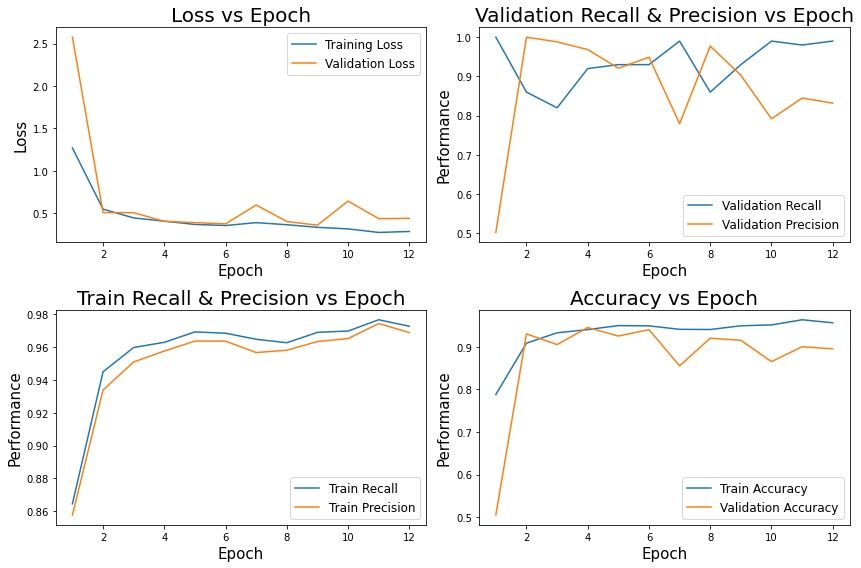

In [28]:
view_history(mlp, "Version5")

In [29]:
model_evaluate(model_mlp_base_5, train_gen, test_gen, val_gen)

7/7 [==============================] - 1s 201ms/step - loss: 0.4409 - precision: 0.8319 - recall: 0.9900 - accuracy: 0.8950


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.272293,95.599085,99.339151,96.065181
1,Test,1.049632,74.280232,99.230766,78.044873
2,Validation,0.440925,83.193278,99.000001,89.499998


Now it seems that we are starting to overfit slightly. Lets adjust our regualrization strength

# MLP Version 6

In [31]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_6 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_6.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_6.add(Dense(64, activation='relu'))
model_mlp_base_6.add(Dense(64, activation='relu'))
model_mlp_base_6.add(Dense(64, activation='relu'))
model_mlp_base_6.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1))) #default value apparently when using l2 as 'l2' is 0.01

# Define output layer
model_mlp_base_6.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_6.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_6.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                12582976  
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 12,595,521
Trainable params: 12,595,521
Non-trainable params: 0
__________________________________________

In [32]:
mlp['Version6'] = train_model(model_mlp_base_6, train_gen, val_gen, total_epochs=15)

Epoch 1/15
158/158 [==============================] - 41s 261ms/step - loss: 5.3904 - precision: 0.8740 - recall: 0.8893 - accuracy: 0.8198 - val_loss: 3.0583 - val_precision: 1.0000 - val_recall: 0.7900 - val_accuracy: 0.8950
Epoch 2/15
158/158 [==============================] - 39s 245ms/step - loss: 2.6367 - precision: 0.9361 - recall: 0.9490 - accuracy: 0.9130 - val_loss: 2.4747 - val_precision: 0.8083 - val_recall: 0.9700 - val_accuracy: 0.8700
Epoch 3/15
158/158 [==============================] - 38s 241ms/step - loss: 2.1563 - precision: 0.9464 - recall: 0.9522 - accuracy: 0.9235 - val_loss: 2.0913 - val_precision: 0.8305 - val_recall: 0.9800 - val_accuracy: 0.8900
Epoch 4/15
158/158 [==============================] - 38s 243ms/step - loss: 1.8449 - precision: 0.9607 - recall: 0.9640 - accuracy: 0.9434 - val_loss: 1.7772 - val_precision: 0.8796 - val_recall: 0.9500 - val_accuracy: 0.9100
Epoch 5/15
158/158 [==============================] - 38s 240ms/step - loss: 1.7042 - precis

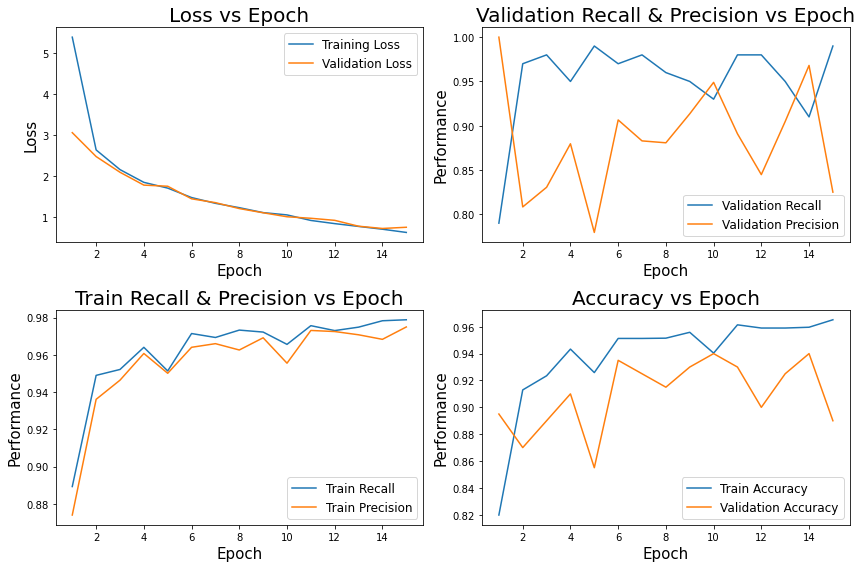

In [33]:
view_history(mlp, "Version6")

In [34]:
model_evaluate(model_mlp_base_6, train_gen, test_gen, val_gen)

7/7 [==============================] - 1s 207ms/step - loss: 0.7480 - precision: 0.8250 - recall: 0.9900 - accuracy: 0.8900


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.583692,96.358043,99.312717,96.661365
1,Test,1.332745,75.291830,99.230766,79.166669
2,Validation,0.748027,82.499999,99.000001,88.999999


It seems we are still overfitting since 

# MLP version 7

In [35]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_7 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_7.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_7.add(Dense(64, activation='relu'))
model_mlp_base_7.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_mlp_base_7.add(Dense(64, activation='relu'))
model_mlp_base_7.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1))) #default value apparently when using l2 as 'l2' is 0.01

# Define output layer
model_mlp_base_7.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_7.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_7.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                12582976  
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 12,595,521
Trainable params: 12,595,521
Non-trainable params: 0
__________________________________________

In [36]:
mlp['Version7'] = train_model(model_mlp_base_7, train_gen, val_gen, total_epochs=15)

Epoch 1/15
158/158 [==============================] - 42s 263ms/step - loss: 5.8245 - precision: 0.8730 - recall: 0.8869 - accuracy: 0.8176 - val_loss: 3.4250 - val_precision: 1.0000 - val_recall: 0.7900 - val_accuracy: 0.8950
Epoch 2/15
158/158 [==============================] - 39s 250ms/step - loss: 3.0555 - precision: 0.9232 - recall: 0.9347 - accuracy: 0.8925 - val_loss: 2.6882 - val_precision: 0.8305 - val_recall: 0.9800 - val_accuracy: 0.8900
Epoch 3/15
158/158 [==============================] - 39s 246ms/step - loss: 2.4739 - precision: 0.9542 - recall: 0.9580 - accuracy: 0.9338 - val_loss: 2.5320 - val_precision: 0.7857 - val_recall: 0.9900 - val_accuracy: 0.8600
Epoch 4/15
158/158 [==============================] - 39s 247ms/step - loss: 2.2831 - precision: 0.9358 - recall: 0.9448 - accuracy: 0.9098 - val_loss: 2.0703 - val_precision: 0.8972 - val_recall: 0.9600 - val_accuracy: 0.9250
Epoch 5/15
158/158 [==============================] - 38s 240ms/step - loss: 1.9330 - precis

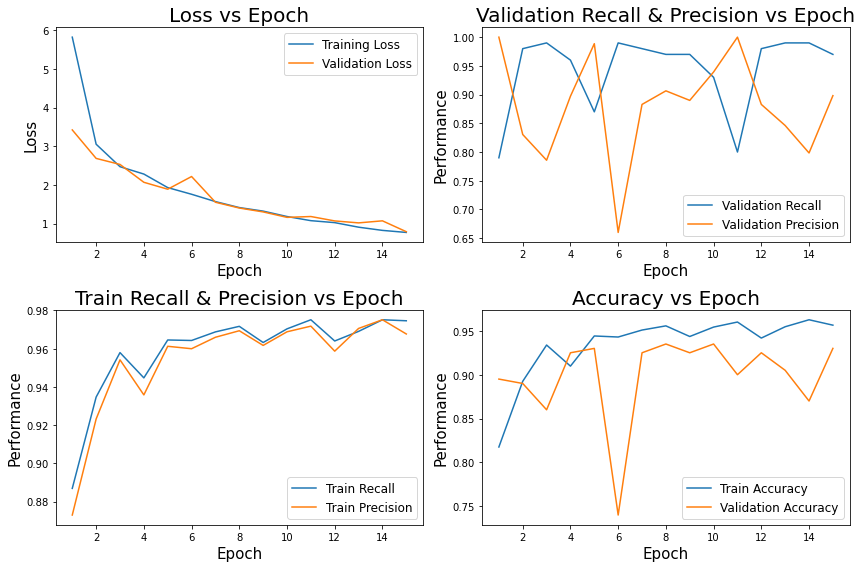

In [37]:
view_history(mlp, "Version7")

In [38]:
model_evaluate(model_mlp_base_7, train_gen, test_gen, val_gen)

7/7 [==============================] - 2s 227ms/step - loss: 0.7919 - precision: 0.8981 - recall: 0.9700 - accuracy: 0.9300


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.705052,98.069292,98.017448,97.058821
1,Test,1.240603,81.052631,98.717946,84.775639
2,Validation,0.791948,89.814812,97.000003,93.000001


# MLP Version 8

In [39]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_8 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_8.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_8.add(Dense(64, activation='relu'))
model_mlp_base_8.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_mlp_base_8.add(Dense(64, activation='relu'))
model_mlp_base_8.add(Dropout(0.2))
model_mlp_base_8.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1))) # default value apparently when using l2 as 'l2' is 0.01

# Define output layer
model_mlp_base_8.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_8.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_8.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                12582976  
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                

In [40]:
mlp['Version8'] = train_model(model_mlp_base_8, train_gen, val_gen, total_epochs=15)

Epoch 1/15
158/158 [==============================] - 41s 261ms/step - loss: 6.2870 - precision: 0.8432 - recall: 0.8421 - accuracy: 0.7601 - val_loss: 3.2149 - val_precision: 0.9773 - val_recall: 0.8600 - val_accuracy: 0.9200
Epoch 2/15
158/158 [==============================] - 41s 262ms/step - loss: 2.6904 - precision: 0.9253 - recall: 0.9463 - accuracy: 0.9022 - val_loss: 2.8951 - val_precision: 0.6135 - val_recall: 1.0000 - val_accuracy: 0.6850
Epoch 3/15
158/158 [==============================] - 39s 246ms/step - loss: 1.9927 - precision: 0.9342 - recall: 0.9638 - accuracy: 0.9217 - val_loss: 1.8901 - val_precision: 0.7734 - val_recall: 0.9900 - val_accuracy: 0.8500
Epoch 4/15
158/158 [==============================] - 39s 244ms/step - loss: 1.5785 - precision: 0.9463 - recall: 0.9643 - accuracy: 0.9320 - val_loss: 1.4229 - val_precision: 0.9143 - val_recall: 0.9600 - val_accuracy: 0.9350
Epoch 5/15
158/158 [==============================] - 39s 245ms/step - loss: 1.2787 - precis

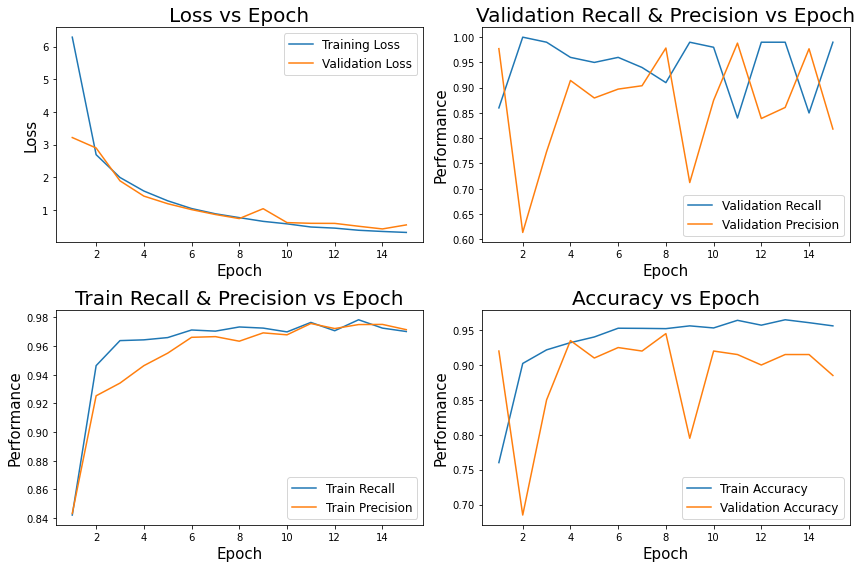

In [41]:
view_history(mlp, "Version8")

In [42]:
model_evaluate(model_mlp_base_8, train_gen, test_gen, val_gen)

7/7 [==============================] - 2s 216ms/step - loss: 0.5413 - precision: 0.8182 - recall: 0.9900 - accuracy: 0.8850


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.302355,95.601320,99.392015,96.104926
1,Test,1.285962,74.280232,99.230766,78.044873
2,Validation,0.541254,81.818181,99.000001,88.499999


Version 6 seems to be our best MLP model because it does not underfit like the models after it. We can see how the losses are very close to one another while in other models we have val loss below the train loss teh majority of the time. It seems its time to upgrade our model to Convolutinal neural Network to see if we can imporve our metrics

# Convolutional Neural Network


Based off our work from the MLP section Version 6 was our best model performance for loss and not overfitting. Lets use that layout and add Convolutional Layers to it

In [25]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_1 = Sequential()

# Define the layers
# Define our Conv layer
cnn_1.add(Conv2D(16, (3,3), 1, activation='relu', padding='same', input_shape=input_shape))
cnn_1.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_1.add(Flatten())

# Define our Dense Layers
cnn_1.add(Dense(64, activation='relu'))
cnn_1.add(Dense(64, activation='relu'))
cnn_1.add(Dense(64, activation='relu'))
cnn_1.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_1.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_1.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16777280  
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 64)               

In [26]:
from functions import train_model

cnn = {}

cnn['Version1'] = train_model(cnn_1, train_gen, val_gen, 15)

Epoch 1/15
158/158 [==============================] - 61s 387ms/step - loss: 3.6666 - precision: 0.8986 - recall: 0.9333 - accuracy: 0.8696 - val_loss: 1.8675 - val_precision: 1.0000 - val_recall: 0.8800 - val_accuracy: 0.9400
Epoch 2/15
158/158 [==============================] - 58s 369ms/step - loss: 1.2677 - precision: 0.9796 - recall: 0.9791 - accuracy: 0.9690 - val_loss: 0.9828 - val_precision: 0.9245 - val_recall: 0.9800 - val_accuracy: 0.9500
Epoch 3/15
158/158 [==============================] - 58s 368ms/step - loss: 0.7324 - precision: 0.9892 - recall: 0.9886 - accuracy: 0.9833 - val_loss: 0.6558 - val_precision: 0.9417 - val_recall: 0.9700 - val_accuracy: 0.9550
Epoch 4/15
158/158 [==============================] - 58s 368ms/step - loss: 0.4817 - precision: 0.9926 - recall: 0.9923 - accuracy: 0.9887 - val_loss: 0.4887 - val_precision: 0.9417 - val_recall: 0.9700 - val_accuracy: 0.9550
Epoch 5/15
158/158 [==============================] - 58s 369ms/step - loss: 0.3155 - precis

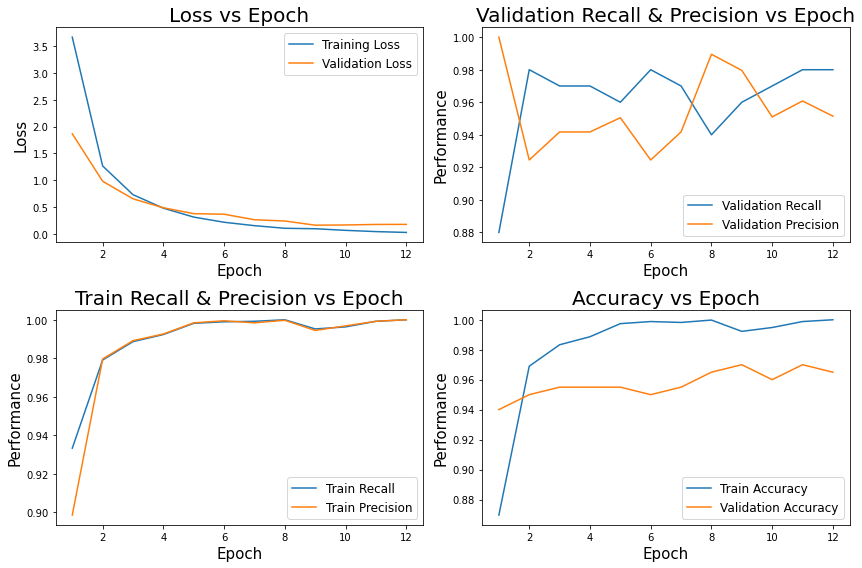

In [27]:
from functions import view_history

view_history(cnn, 'Version1')

In [28]:
from functions import model_evaluate

model_evaluate(cnn_1, train_gen, test_gen, val_gen)

7/7 [==============================] - 2s 229ms/step - loss: 0.1648 - precision: 0.9796 - recall: 0.9600 - accuracy: 0.9700


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.079238,99.973524,99.814963,99.841017
1,Test,0.765956,77.045906,98.974359,80.929488
2,Validation,0.164755,97.959185,95.999998,97.000003


# CNN Version 2

In [29]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_2 = Sequential()

# Define the layers
# Define our Conv layer
cnn_2.add(Conv2D(32, (3,3), 1, activation='relu', padding='same', input_shape=input_shape))
cnn_2.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_2.add(Flatten())

# Define our Dense Layers
cnn_2.add(Dense(64, activation='relu'))
cnn_2.add(Dense(64, activation='relu'))
cnn_2.add(Dense(64, activation='relu'))
cnn_2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_2.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_2.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 524288)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                33554496  
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_22 (Dense)             (None, 64)               

In [30]:
from functions import train_model

cnn['Version2'] = train_model(cnn_2, train_gen, val_gen, 15)

Epoch 1/15
158/158 [==============================] - 84s 529ms/step - loss: 3.8168 - precision: 0.9242 - recall: 0.9356 - accuracy: 0.8923 - val_loss: 2.1586 - val_precision: 0.8761 - val_recall: 0.9900 - val_accuracy: 0.9250
Epoch 2/15
158/158 [==============================] - 80s 507ms/step - loss: 1.6150 - precision: 0.9817 - recall: 0.9786 - accuracy: 0.9702 - val_loss: 1.3453 - val_precision: 0.9697 - val_recall: 0.9600 - val_accuracy: 0.9650
Epoch 3/15
158/158 [==============================] - 81s 511ms/step - loss: 1.1259 - precision: 0.9907 - recall: 0.9900 - accuracy: 0.9855 - val_loss: 1.1336 - val_precision: 0.9000 - val_recall: 0.9900 - val_accuracy: 0.9400
Epoch 4/15
158/158 [==============================] - 80s 506ms/step - loss: 0.8430 - precision: 0.9955 - recall: 0.9934 - accuracy: 0.9917 - val_loss: 0.9139 - val_precision: 0.9245 - val_recall: 0.9800 - val_accuracy: 0.9500
Epoch 5/15
158/158 [==============================] - 80s 508ms/step - loss: 0.6307 - precis

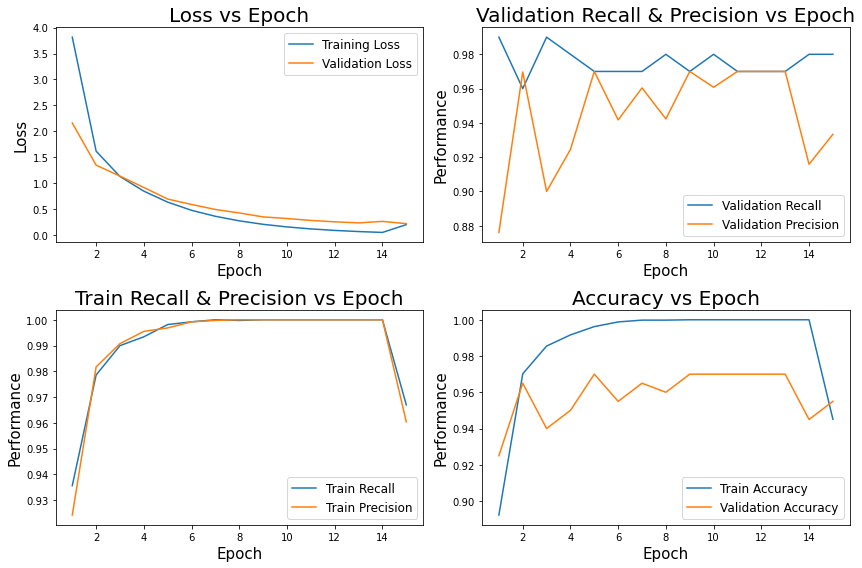

In [31]:
from functions import view_history

view_history(cnn, 'Version2')

In [32]:
from functions import model_evaluate

model_evaluate(cnn_2, train_gen, test_gen, val_gen)

7/7 [==============================] - 2s 241ms/step - loss: 0.2157 - precision: 0.9333 - recall: 0.9800 - accuracy: 0.9550


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.076724,99.106437,99.682790,99.085850
1,Test,0.986195,74.615383,99.487180,78.525639
2,Validation,0.215678,93.333334,98.000002,95.499998


Eventhough our train and validation did well our test has a big loss performance drop in comparison to our previous attempt. It does not seem we are overfitting yet. Lets add another conv layer

# CNN Version 3

In [10]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_3 = Sequential()

# Define the layers
# Define our Conv layer
cnn_3.add(Conv2D(16, (3,3), 1, activation='relu', padding='same', input_shape=input_shape))
cnn_3.add(MaxPool2D())
cnn_3.add(Conv2D(16, (3,3), 1, activation='relu', padding='same'))
cnn_3.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_3.add(Flatten())

# Define our Dense Layers
cnn_3.add(Dense(64, activation='relu'))
cnn_3.add(Dense(64, activation='relu'))
cnn_3.add(Dense(64, activation='relu'))
cnn_3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_3.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_3.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_3.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4194368   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4

Epoch 1/15
  1/123 [..............................] - ETA: 0s - loss: 7.0482 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.4062WARNING:tensorflow:From c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
123/123 [==============================] - 89s 722ms/step - loss: 3.5746 - precision: 0.8474 - recall: 0.9353 - accuracy: 0.8388 - val_loss: 1.3941 - val_precision: 0.9930 - val_recall: 0.9751 - val_accuracy: 0.9715
Epoch 2/15
123/123 [==============================] - 79s 639ms/step - loss: 0.8106 - precision: 0.9646 - recall: 0.9629 - accuracy: 0.9499 - val_loss: 0.4082 - val_precision: 0.9973 - val_recall: 0.9639 - val_accuracy: 0.9653
Epoch 3/15
123/123 [==============================] - 79s 644ms/step - loss: 0.2752 - precision: 0.9818 - recall: 0.9739

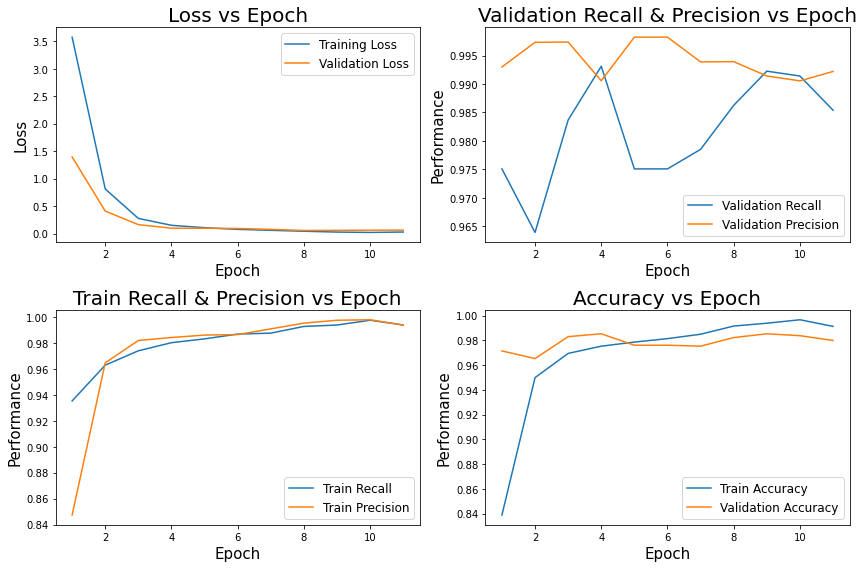

41/41 [==============================] - 14s 332ms/step - loss: 0.0559 - precision: 0.9939 - recall: 0.9863 - accuracy: 0.9823


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.030021,99.742645,99.779332,99.669546
1,Test,0.795288,78.269619,99.743587,82.532054
2,Validation,0.055914,99.393940,98.625427,98.228043


In [11]:
from functions import train_model, view_history, model_evaluate
cnn={}
# Train model
cnn['Version3'] = train_model(cnn_3, train_gen, val_gen, 15)

# Display history 
view_history(cnn, 'Version3')

# Evaluate Model
model_evaluate(cnn_3, train_gen, test_gen, val_gen)

Our test loss is very simialr to the V1. Perhaps the answer is that we are actually overfitting. For some reason our train and val metrics and loss is always better significantly than our test. Perhaps we need to add more regularization to the model

# CNN Version 4


In [12]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_4 = Sequential()

# Define the layers
# Define our Conv layer
cnn_4.add(Conv2D(16, (3,3), 1, activation='relu', padding='same', input_shape=input_shape))
cnn_4.add(MaxPool2D())
cnn_4.add(Conv2D(16, (3,3), 1, activation='relu', padding='same'))
cnn_4.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_4.add(Flatten())

# Define our Dense Layers
cnn_4.add(Dense(64, activation='relu'))
cnn_4.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
cnn_4.add(Dense(64, activation='relu'))
cnn_4.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_4.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_4.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_4.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4194368   
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

Epoch 1/15
123/123 [==============================] - 82s 664ms/step - loss: 6.5906 - precision: 0.9230 - recall: 0.9508 - accuracy: 0.8790 - val_loss: 2.6319 - val_precision: 0.9982 - val_recall: 0.9442 - val_accuracy: 0.9484
Epoch 2/15
123/123 [==============================] - 78s 636ms/step - loss: 1.4369 - precision: 0.9672 - recall: 0.9658 - accuracy: 0.9537 - val_loss: 0.7093 - val_precision: 0.9956 - val_recall: 0.9759 - val_accuracy: 0.9746
Epoch 3/15
123/123 [==============================] - 78s 638ms/step - loss: 0.4836 - precision: 0.9823 - recall: 0.9801 - accuracy: 0.9741 - val_loss: 0.3155 - val_precision: 0.9965 - val_recall: 0.9863 - val_accuracy: 0.9846
Epoch 4/15
123/123 [==============================] - 78s 636ms/step - loss: 0.2825 - precision: 0.9798 - recall: 0.9794 - accuracy: 0.9718 - val_loss: 0.1962 - val_precision: 0.9922 - val_recall: 0.9897 - val_accuracy: 0.9838
Epoch 5/15
123/123 [==============================] - 78s 635ms/step - loss: 0.1901 - precis

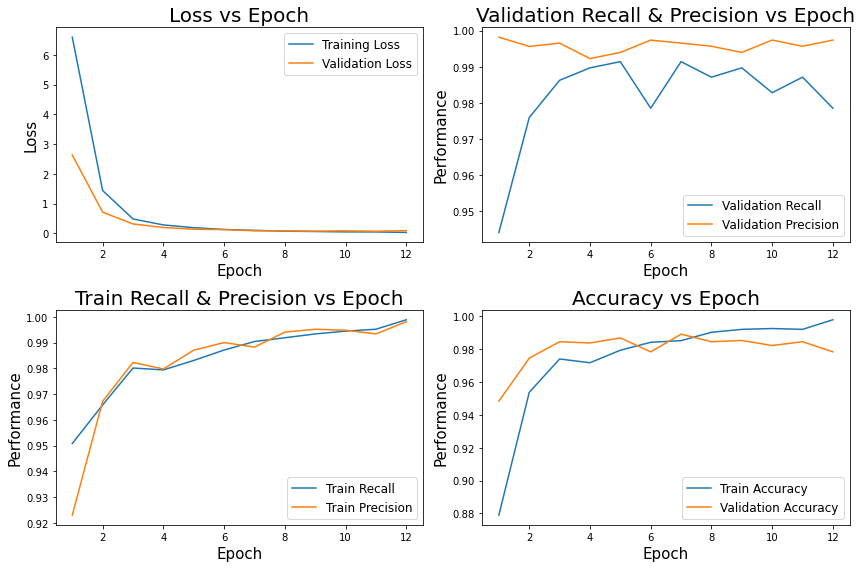

41/41 [==============================] - 13s 323ms/step - loss: 0.0733 - precision: 0.9940 - recall: 0.9897 - accuracy: 0.9854


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.041288,99.816382,99.963224,99.847484
1,Test,0.831545,77.600002,99.487180,81.730771
2,Validation,0.073262,99.396032,98.969072,98.536211


In [13]:
from functions import view_history, model_evaluate, train_model
# Train model
cnn = {}

cnn['Version4'] = train_model(cnn_4, train_gen, val_gen, 15)

# Display history 
view_history(cnn, 'Version4')

# Evaluate Model
model_evaluate(cnn_4, train_gen, test_gen, val_gen)

This model did overft. Both losses diverged from eachother. Lets restart from version 1 since it seems we have overfitting all the time. 

# CNN Version 5 

In [14]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_5 = Sequential()

# Define the layers
# Define our Conv layer
cnn_5.add(Conv2D(16, (3,3), 1, activation='relu', padding='same', input_shape=input_shape))
cnn_5.add(MaxPool2D())
cnn_5.add(Conv2D(16, (3,3), 1, activation='relu', padding='same'))
cnn_5.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_5.add(Flatten())

# Define our Dense Layers
cnn_5.add(Dense(64, activation='relu'))
cnn_5.add(Dropout(0.2, seed=42))
cnn_5.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
cnn_5.add(Dense(64, activation='relu'))
cnn_5.add(Dropout(0.2, seed=42))
cnn_5.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_5.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_5.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_5.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4194368   
_________________________________________________________________
dropout (Dropout)            (None, 64)               

Epoch 1/15
123/123 [==============================] - 81s 656ms/step - loss: 7.0138 - precision: 0.8675 - recall: 0.9405 - accuracy: 0.8043 - val_loss: 2.6580 - val_precision: 0.9929 - val_recall: 0.9579 - val_accuracy: 0.9561
Epoch 2/15
123/123 [==============================] - 78s 635ms/step - loss: 1.3714 - precision: 0.9607 - recall: 0.9540 - accuracy: 0.9413 - val_loss: 0.5828 - val_precision: 0.9973 - val_recall: 0.9493 - val_accuracy: 0.9522
Epoch 3/15
123/123 [==============================] - 78s 634ms/step - loss: 0.3517 - precision: 0.9755 - recall: 0.9669 - accuracy: 0.9603 - val_loss: 0.1573 - val_precision: 0.9923 - val_recall: 0.9931 - val_accuracy: 0.9869
Epoch 4/15
123/123 [==============================] - 79s 645ms/step - loss: 0.1602 - precision: 0.9822 - recall: 0.9750 - accuracy: 0.9705 - val_loss: 0.1017 - val_precision: 0.9914 - val_recall: 0.9888 - val_accuracy: 0.9823
Epoch 5/15
123/123 [==============================] - 78s 635ms/step - loss: 0.1175 - precis

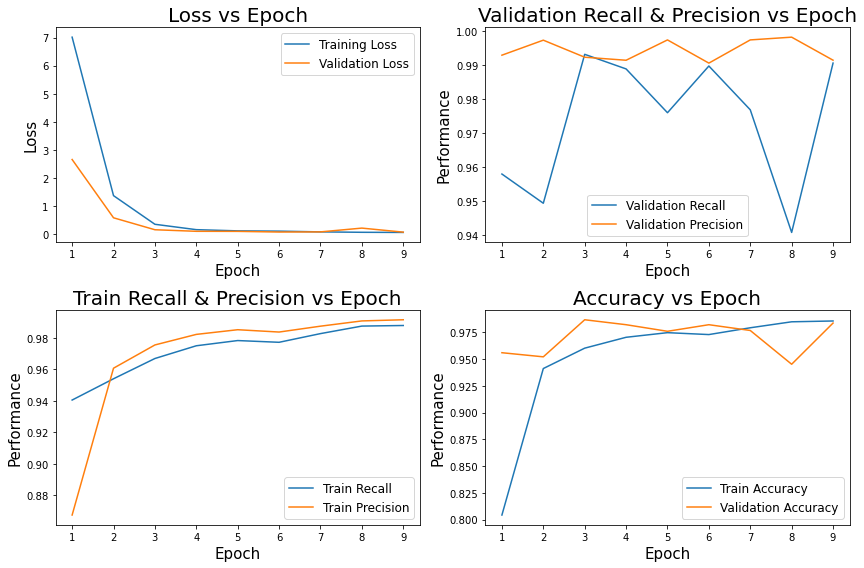

41/41 [==============================] - 13s 325ms/step - loss: 0.0759 - precision: 0.9905 - recall: 0.9897 - accuracy: 0.9823


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.080311,98.359460,99.227655,98.322320
1,Test,0.652557,78.498983,99.230766,82.532054
2,Validation,0.075873,99.054170,98.969072,98.228043


In [15]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version5'] = train_model(cnn_5, train_gen, val_gen, 15)

# Display history 
view_history(cnn, 'Version5')

# Evaluate Model
model_evaluate(cnn_5, train_gen, test_gen, val_gen)

This is good progress as our test loss is now .2 less than what it was. Adding more regularization is helping. Lets keep the same architecture but increase dropout 

# CNN Version 6

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_6 = Sequential()

# Define the layers
# Define our Conv layer
cnn_6.add(Conv2D(16, (3,3), 1, activation='relu', padding='same', input_shape=input_shape))
cnn_6.add(MaxPool2D())
cnn_6.add(Conv2D(16, (3,3), 1, activation='relu', padding='same'))
cnn_6.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_6.add(Flatten())

# Define our Dense Layers
cnn_6.add(Dense(64, activation='relu'))
cnn_6.add(Dropout(0.4, seed=42))
cnn_6.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
cnn_6.add(Dense(64, activation='relu'))
cnn_6.add(Dropout(0.4, seed=42))
cnn_6.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_6.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_6.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_6.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4194368   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

Epoch 1/15
123/123 [==============================] - 80s 653ms/step - loss: 6.7393 - precision: 0.7636 - recall: 0.9714 - accuracy: 0.6807 - val_loss: 2.3041 - val_precision: 0.9599 - val_recall: 0.9665 - val_accuracy: 0.9337
Epoch 2/15
123/123 [==============================] - 78s 633ms/step - loss: 1.2199 - precision: 0.9149 - recall: 0.9452 - accuracy: 0.9014 - val_loss: 0.3997 - val_precision: 0.9673 - val_recall: 0.9897 - val_accuracy: 0.9607
Epoch 3/15
123/123 [==============================] - 78s 633ms/step - loss: 0.3792 - precision: 0.9441 - recall: 0.9625 - accuracy: 0.9347 - val_loss: 0.1472 - val_precision: 0.9930 - val_recall: 0.9820 - val_accuracy: 0.9777
Epoch 4/15
123/123 [==============================] - 79s 641ms/step - loss: 0.2642 - precision: 0.9621 - recall: 0.9618 - accuracy: 0.9474 - val_loss: 0.1162 - val_precision: 0.9930 - val_recall: 0.9759 - val_accuracy: 0.9723
Epoch 5/15
123/123 [==============================] - 78s 635ms/step - loss: 0.2339 - precis

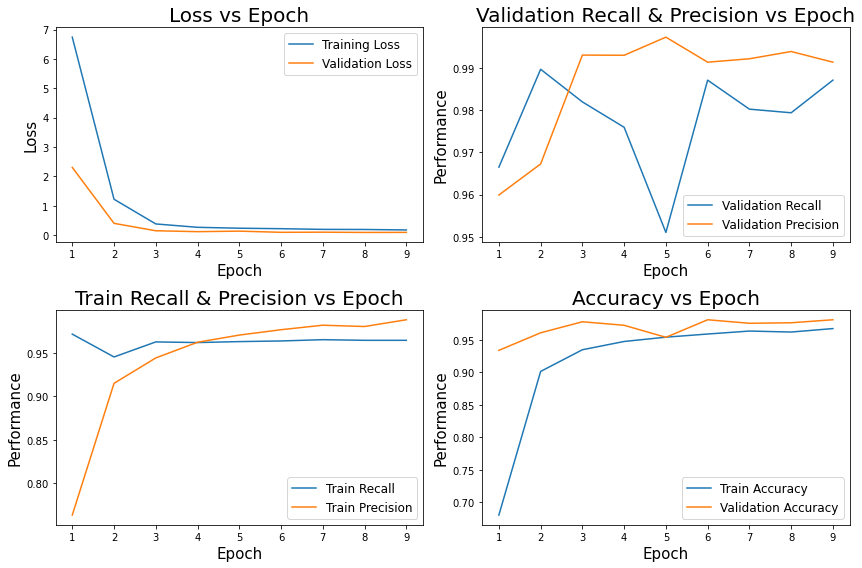

41/41 [==============================] - 13s 327ms/step - loss: 0.0944 - precision: 0.9914 - recall: 0.9871 - accuracy: 0.9807


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.186101,97.659105,98.197865,97.127604
1,Test,0.748908,79.917186,98.974359,83.814102
2,Validation,0.094362,99.137187,98.711342,98.073959


In [18]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version6'] = train_model(cnn_6, train_gen, val_gen, 15)

# Display history 
view_history(cnn, 'Version6')

# Evaluate Model
model_evaluate(cnn_6, train_gen, test_gen, val_gen)

We can see how we start to overfit with every epoch very slowly. To confirm lets just increase the information recieved by the dense layers by increase our filters since it is a little difficult to tell.

# CNN version 7

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_7 = Sequential()

# Define the layers
# Define our Conv layer
cnn_7.add(Conv2D(16, (3,3), 1, activation='relu', padding='same', input_shape=input_shape))
cnn_7.add(MaxPool2D())
cnn_7.add(Conv2D(16, (3,3), 1, activation='relu', padding='same'))
cnn_7.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_7.add(Flatten())

# Define our Dense Layers
cnn_7.add(Dense(64, activation='relu'))
cnn_7.add(Dropout(0.4, seed=42))
cnn_7.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
cnn_7.add(Dropout(0.4, seed=42))
cnn_7.add(Dense(64, activation='relu'))
cnn_7.add(Dropout(0.4, seed=42))
cnn_7.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_7.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_7.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_7.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4194368   
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

Epoch 1/15
123/123 [==============================] - 81s 657ms/step - loss: 6.8111 - precision: 0.8143 - recall: 0.9421 - accuracy: 0.7372 - val_loss: 2.3561 - val_precision: 0.9796 - val_recall: 0.9897 - val_accuracy: 0.9723
Epoch 2/15
123/123 [==============================] - 79s 639ms/step - loss: 1.2127 - precision: 0.9213 - recall: 0.9599 - accuracy: 0.9156 - val_loss: 0.3922 - val_precision: 0.9939 - val_recall: 0.9734 - val_accuracy: 0.9707
Epoch 3/15
123/123 [==============================] - 78s 634ms/step - loss: 0.3170 - precision: 0.9599 - recall: 0.9595 - accuracy: 0.9443 - val_loss: 0.1385 - val_precision: 0.9964 - val_recall: 0.9631 - val_accuracy: 0.9638
Epoch 4/15
123/123 [==============================] - 78s 637ms/step - loss: 0.1822 - precision: 0.9773 - recall: 0.9673 - accuracy: 0.9619 - val_loss: 0.0786 - val_precision: 0.9948 - val_recall: 0.9897 - val_accuracy: 0.9861
Epoch 5/15
123/123 [==============================] - 78s 636ms/step - loss: 0.1462 - precis

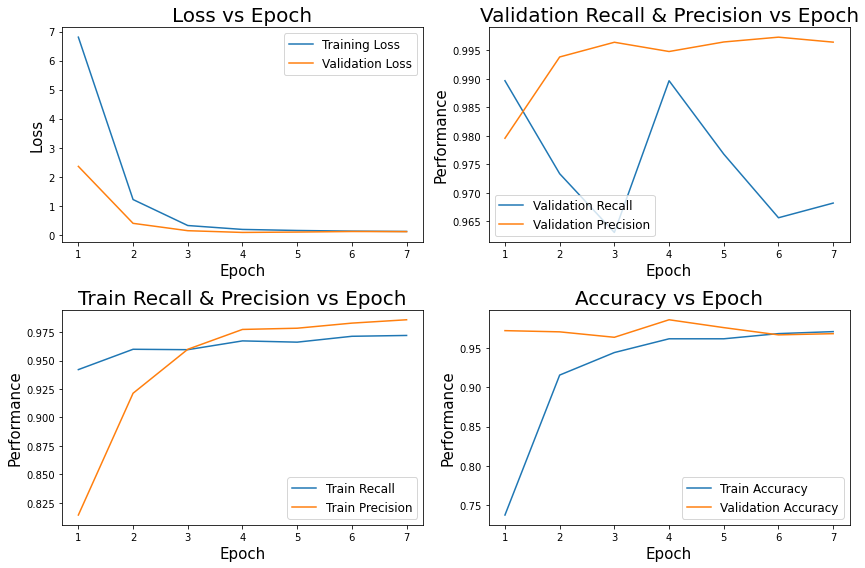

41/41 [==============================] - 13s 324ms/step - loss: 0.0786 - precision: 0.9948 - recall: 0.9897 - accuracy: 0.9861


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.109406,97.566289,98.786318,97.458059
1,Test,0.656452,78.904665,99.743587,83.173078
2,Validation,0.078568,99.481863,98.969072,98.613250


In [20]:
from functions import model_evaluate, train_model, view_history
cnn = {}

# Train model
cnn['Version7'] = train_model(cnn_7, train_gen, val_gen, 15)

# Display history 
view_history(cnn, 'Version7')

# Evaluate Model
model_evaluate(cnn_7, train_gen, test_gen, val_gen)

It seems that version 5 does better. We can attempt to generalize better by maybe adding more dense neurons to the first layer

# CNN Version 8

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_8 = Sequential()

# Define the layers
# Define our Conv layer
cnn_8.add(Conv2D(16, (3,3), 1, activation='relu', padding='same', input_shape=input_shape))
cnn_8.add(MaxPool2D())
cnn_8.add(Conv2D(16, (3,3), 1, activation='relu', padding='same'))
cnn_8.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_8.add(Flatten())

# Define our Dense Layers
cnn_8.add(Dense(128, activation='relu'))
cnn_8.add(Dropout(.2, seed=42))
cnn_8.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
cnn_8.add(Dense(64, activation='relu'))
cnn_8.add(Dropout(.2, seed=42))
cnn_8.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_8.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_8.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_8.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               8388736   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)              

Epoch 1/15
123/123 [==============================] - 82s 668ms/step - loss: 7.1660 - precision: 0.8861 - recall: 0.9518 - accuracy: 0.8363 - val_loss: 2.2743 - val_precision: 0.9981 - val_recall: 0.9270 - val_accuracy: 0.9330
Epoch 2/15
123/123 [==============================] - 79s 645ms/step - loss: 1.0262 - precision: 0.9711 - recall: 0.9640 - accuracy: 0.9553 - val_loss: 0.3363 - val_precision: 0.9965 - val_recall: 0.9863 - val_accuracy: 0.9846
Epoch 3/15
123/123 [==============================] - 79s 644ms/step - loss: 0.2337 - precision: 0.9796 - recall: 0.9735 - accuracy: 0.9677 - val_loss: 0.1184 - val_precision: 0.9906 - val_recall: 0.9931 - val_accuracy: 0.9854
Epoch 4/15
123/123 [==============================] - 81s 657ms/step - loss: 0.1370 - precision: 0.9783 - recall: 0.9772 - accuracy: 0.9692 - val_loss: 0.0810 - val_precision: 0.9906 - val_recall: 0.9931 - val_accuracy: 0.9854
Epoch 5/15
123/123 [==============================] - 79s 645ms/step - loss: 0.0987 - precis

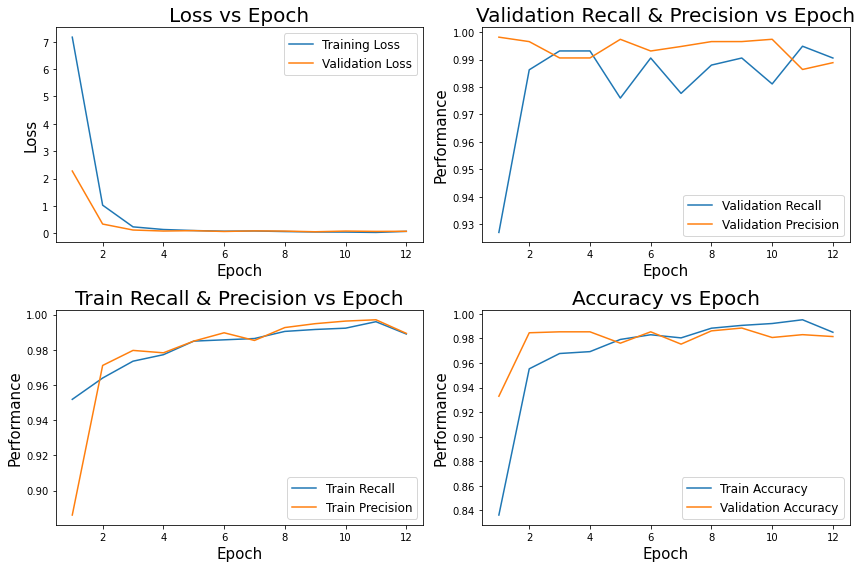

41/41 [==============================] - 15s 355ms/step - loss: 0.0548 - precision: 0.9965 - recall: 0.9905 - accuracy: 0.9884


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.034698,99.742645,99.779332,99.669546
1,Test,0.811040,78.427422,99.743587,82.692307
2,Validation,0.054783,99.654281,99.054980,98.844373


In [23]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version 8'] = train_model(cnn_8, train_gen, val_gen, 15)

# View History 
view_history(cnn, 'Version 8')

# Evaluate model
model_evaluate(cnn_8, train_gen, test_gen, val_gen)

I would say adding more neurons actually did not give any performance gain at all. This is where we should do data augmentation using Version 5

In [25]:
cnn_5.save("models/cnn5.keras")

In [26]:
cnn_5.save("models/cnn5control.keras")

# Data Augmentation

I made a function that augments our data and normalizes the data for training. Lets retrive our new data generators. 

In [27]:
# Call data augmentation fucntion
from functions import data_augmentation

train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(256, 32, train_data_dir, test_data_dir, val_data_dir)

Found 3934 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1298 images belonging to 2 classes.


Now that we have our data generators we can proceed to continue training our cnn10 & cnn 11 models with data augmentation

In [28]:
from tensorflow.keras.models import load_model

model_1 = load_model("models/cnn5.keras")

In [29]:
from functions import model_evaluate, view_history, train_model
cnn_aug_model1 = {}

# Train the model
cnn_aug_model1['Version1'] = train_model(model_1, train_gen_aug, val_gen_aug, 15)

# Visualize history 
view_history(cnn_aug_model1, 'Version1')

# Evaluate model
model_evaluate(model_1, train_gen_aug, test_gen_aug, val_gen_aug)

Epoch 1/15
 24/123 [====>.........................] - ETA: 1:32 - loss: 0.7597 - precision: 0.6985 - recall: 0.7064 - accuracy: 0.5885

In [17]:
# Save our model for augmented training
model_1.save("models/cnn9_aug.keras")

Our losses in our test are much better. Every loss decreases suggetsing that the model is learning better. Unfortunartly our metrics did not improve by much however this model version is much more reliable then the pervious non augmented version

# Transfer Learning

Another method to use here would be to use an already pre trained network and see the results with our network

In [21]:
# Initialize Base
from keras.applications import VGG19
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Load in the pretrained CNN
cnn_base_vgg = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
    )

# Make configuration
model_pre = Sequential()
model_pre.add(cnn_base_vgg)
model_pre.add(Flatten())

# Define the same dense layers with our best cnn version that I made 
# Define our Dense Layers
model_pre.add(Dense(128, activation='relu'))
model_pre.add(Dropout(.2, seed=42))
model_pre.add(Dense(64, activation='relu'))
model_pre.add(Dropout(.2, seed=42))
model_pre.add(Dense(64, activation='relu'))
model_pre.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
model_pre.add(Dense(1, activation='sigmoid'))

# Define the pretrained model as an exclusion from changing its weights
cnn_base_vgg.trainable = False


In [22]:
model_pre.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_pre.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)               

Epoch 1/15
  1/158 [..............................] - ETA: 0s - loss: 7.0548 - precision: 0.6897 - recall: 0.8696 - accuracy: 0.6250WARNING:tensorflow:From c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
158/158 [==============================] - 385s 2s/step - loss: 3.3854 - precision: 0.8720 - recall: 0.9025 - accuracy: 0.8271 - val_loss: 1.3397 - val_precision: 0.8900 - val_recall: 0.8900 - val_accuracy: 0.8900
Epoch 2/15
158/158 [==============================] - 376s 2s/step - loss: 0.7063 - precision: 0.9429 - recall: 0.9204 - accuracy: 0.8983 - val_loss: 0.7677 - val_precision: 0.6623 - val_recall: 1.0000 - val_accuracy: 0.7450
Epoch 3/15
158/158 [==============================] - 377s 2s/step - loss: 0.3146 - precision: 0.9425 - recall: 0.9233 - accuracy: 0

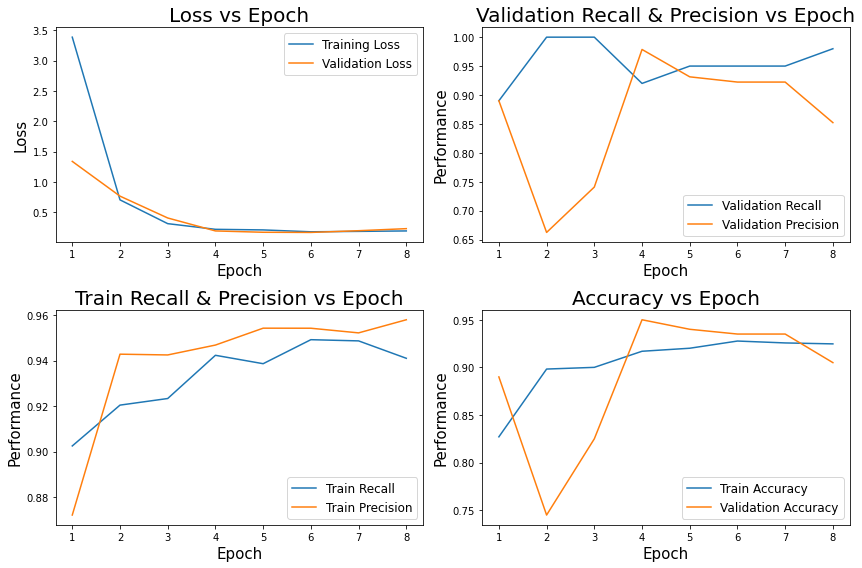

7/7 [==============================] - 12s 2s/step - loss: 0.1727 - precision: 0.9314 - recall: 0.9500 - accuracy: 0.9400


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.160609,96.011698,95.453346,93.600953
1,Test,0.234072,89.252335,97.948718,91.346157
2,Validation,0.172722,93.137252,94.999999,94.000000


In [23]:
from functions import model_evaluate, view_history, train_model
cnn_aug_model2 = {}

# Train the model
cnn_aug_model2['Version1'] = train_model(model_pre, train_gen_aug, val_gen_aug, 15)

# Visualize history 
view_history(cnn_aug_model2, 'Version1')

# Evaluate model
model_evaluate(model_pre, train_gen_aug, test_gen_aug, val_gen_aug)

In [24]:
model_pre.save("models/cnnpre.keras")

Using the pretrained architecture we see how our loss are similar acorss the board. We perform better using the VGG19 according to our metrics. 